In [2]:
from common_imports import *
from helper import *

# To plot pretty figures
%matplotlib widget

Using TensorFlow backend.


1.13.1


### Train a DNN on the modified dataset

Creating data...


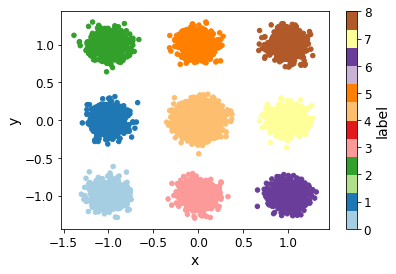

Train Size: (5400, 2)
Test Size: (600,)
Categories: [array([0, 1])]


In [3]:
# Get split returns a generator
# List comprehension is one way to evaluate a generator

original_data, modded_samples, training_labels, original_labels = simulate_blobs(class_size=6000)

# Separating a hold out set that will be used for validation later
X_train, y_train, X_test, y_test, y_original, X_valid, y_valid, y_valid_original = get_train_test_val(modded_samples, original_labels, training_labels)


print("Train Size:", X_train.shape)
print("Test Size:", y_test.shape)


hot_encoder = dfHotEncoder()
hot_encoder.fit(training_labels)
print("Categories:", hot_encoder.categories_)

In [4]:
NUM_FEATURES = X_train.shape[1]
NUM_LABELS = len(hot_encoder.categories_[0])

In [5]:
def build_dnn(num_features, num_nodes = 16, depth = 2, num_labels=2, activation = "elu"):
    
    keras.backend.clear_session()

    nn = keras.models.Sequential()
    Dense = keras.layers.Dense
    
    # Using He initialization
    he_init = tf.keras.initializers.he_uniform()
    
    nn.add(Dense(units = num_nodes, activation=activation, input_dim=num_features,
                kernel_initializer=he_init))
    
    for i in range(1,depth):
        nn.add(Dense(units = num_nodes, activation=activation,
                    kernel_initializer=he_init))

    nn.add(Dense(units=num_labels, activation= "softmax",
                kernel_initializer=he_init))
    
    nn.compile(loss="categorical_crossentropy",
                  optimizer='sgd',
                  metrics=['accuracy'])
    
    return nn

def train_model(model, X, y, epochs=30, batch_size=20, verbose=0):
    
    ZScaler = StandardScaler().fit(X)
    
    X_train = ZScaler.transform(X)
    y_train = hot_encoder.transform(y)

    history = model.fit(X_train, y_train, epochs=epochs, batch_size = batch_size, verbose=verbose)
    
    return history, ZScaler


In [5]:
nn = build_dnn(NUM_FEATURES)
%time history, Zscaler = train_model(nn, X_train, y_train, epochs=50, batch_size=20)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
CPU times: user 14 s, sys: 4.27 s, total: 18.3 s
Wall time: 8.14 s


In [6]:
# Plotting results from history
# plot_history(history)

In [7]:
nn.evaluate(Zscaler.transform(X_test),hot_encoder.transform(y_test))

600/600 [==============================] - 0s 51us/step


[0.0008571491440913329, 1.0]

## Performing LRP

In [19]:
def perform_analysis(model, analyzer, data, labels=[]):
    analysis = analyzer.analyze(data)
    prediction = model.predict(data)
    
    df_anal = pd.DataFrame(analysis)
    
    return df_anal


scaled_samples = Zscaler.transform(X_valid)

# Getting all the samples that can be correctly predicted
all_samples, _labels, correct_idxs = getCorrectPredictions(nn, scaled_samples, y_valid, enc = hot_encoder)
all_labels = y_valid_original[correct_idxs]


# Stripping the softmax activation from the model
model_w_softmax = nn
model = iutils.keras.graph.model_wo_softmax(model_w_softmax)

# Creating an analyzer
lrp_E = innvestigate.analyzer.relevance_based.relevance_analyzer.LRPEpsilon(model=model, epsilon=1e-3)
# lrp_Z = innvestigate.analyzer.relevance_based.relevance_analyzer.LRPZPlus(model=model)

all_lrp_E = perform_analysis(model,lrp_E, all_samples)

NameError: name 'Zscaler' is not defined

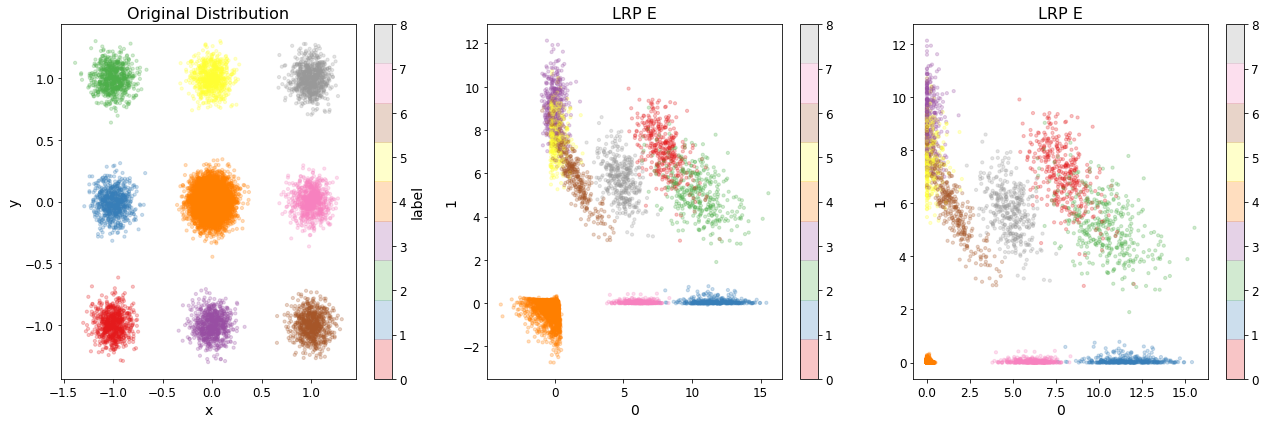

In [9]:
plt.close("Positive Only LRP")
fig, axs = plt.subplots(1,3, figsize=(18,6), num="Positive Only LRP")

plot_args["c"] = "label"
original_data.plot(ax=axs[0], title="Original Distribution", **plot_args)

plot_args["c"] = all_labels
all_lrp_E.plot(ax=axs[1], title="LRP E", **plot_args)

pos_lrp = all_lrp_E.copy()
pos_lrp[pos_lrp<0] = 0
pos_lrp["label"] = all_labels.values
pos_lrp.plot(ax=axs[2],title="LRP E", **plot_args)

plt.tight_layout()
plt.show()

# Peforming an analysis on depths

In [23]:
import innvestigate
import innvestigate.utils as iutils

plot_args = {"kind":"scatter", "x":0,  "y":1, "c":"label", "cmap": "Set1", "s":10, "alpha":0.25}

def runDNN(depth, epochs=50):
    nn = build_dnn(NUM_FEATURES)
    history, ZScaler = train_model(nn, X_train, y_train, 
                                   epochs=epochs, batch_size=20)
    
    
    scaled_samples = ZScaler.transform(X_valid)
    final_acc = nn.evaluate(scaled_samples,hot_encoder.transform(y_valid), verbose=0)

    # Getting all the samples that can be correctly predicted
    cp_samples, _labels, correct_idxs = getCorrectPredictions(nn, scaled_samples, y_valid, enc = hot_encoder)
    lrp_labels = y_valid_original[correct_idxs]


    # Stripping the softmax activation from the model
    model_w_softmax = nn
    model = iutils.keras.graph.model_wo_softmax(model_w_softmax)

    # Creating an analyzer
    lrp_E = innvestigate.analyzer.relevance_based.relevance_analyzer.LRPEpsilon(model=model, epsilon=1e-3)
    lrp_results = lrp_E.analyze(cp_samples)
    
    return (final_acc, lrp_results, lrp_labels)

Prediction Accuracy
6000/6000 [==============================] - 0s 9us/step
Scores on data set: loss=0.001 accuracy=1.0000
Prediction Accuracy
6000/6000 [==============================] - 0s 9us/step
Scores on data set: loss=0.001 accuracy=1.0000


KeyboardInterrupt: 

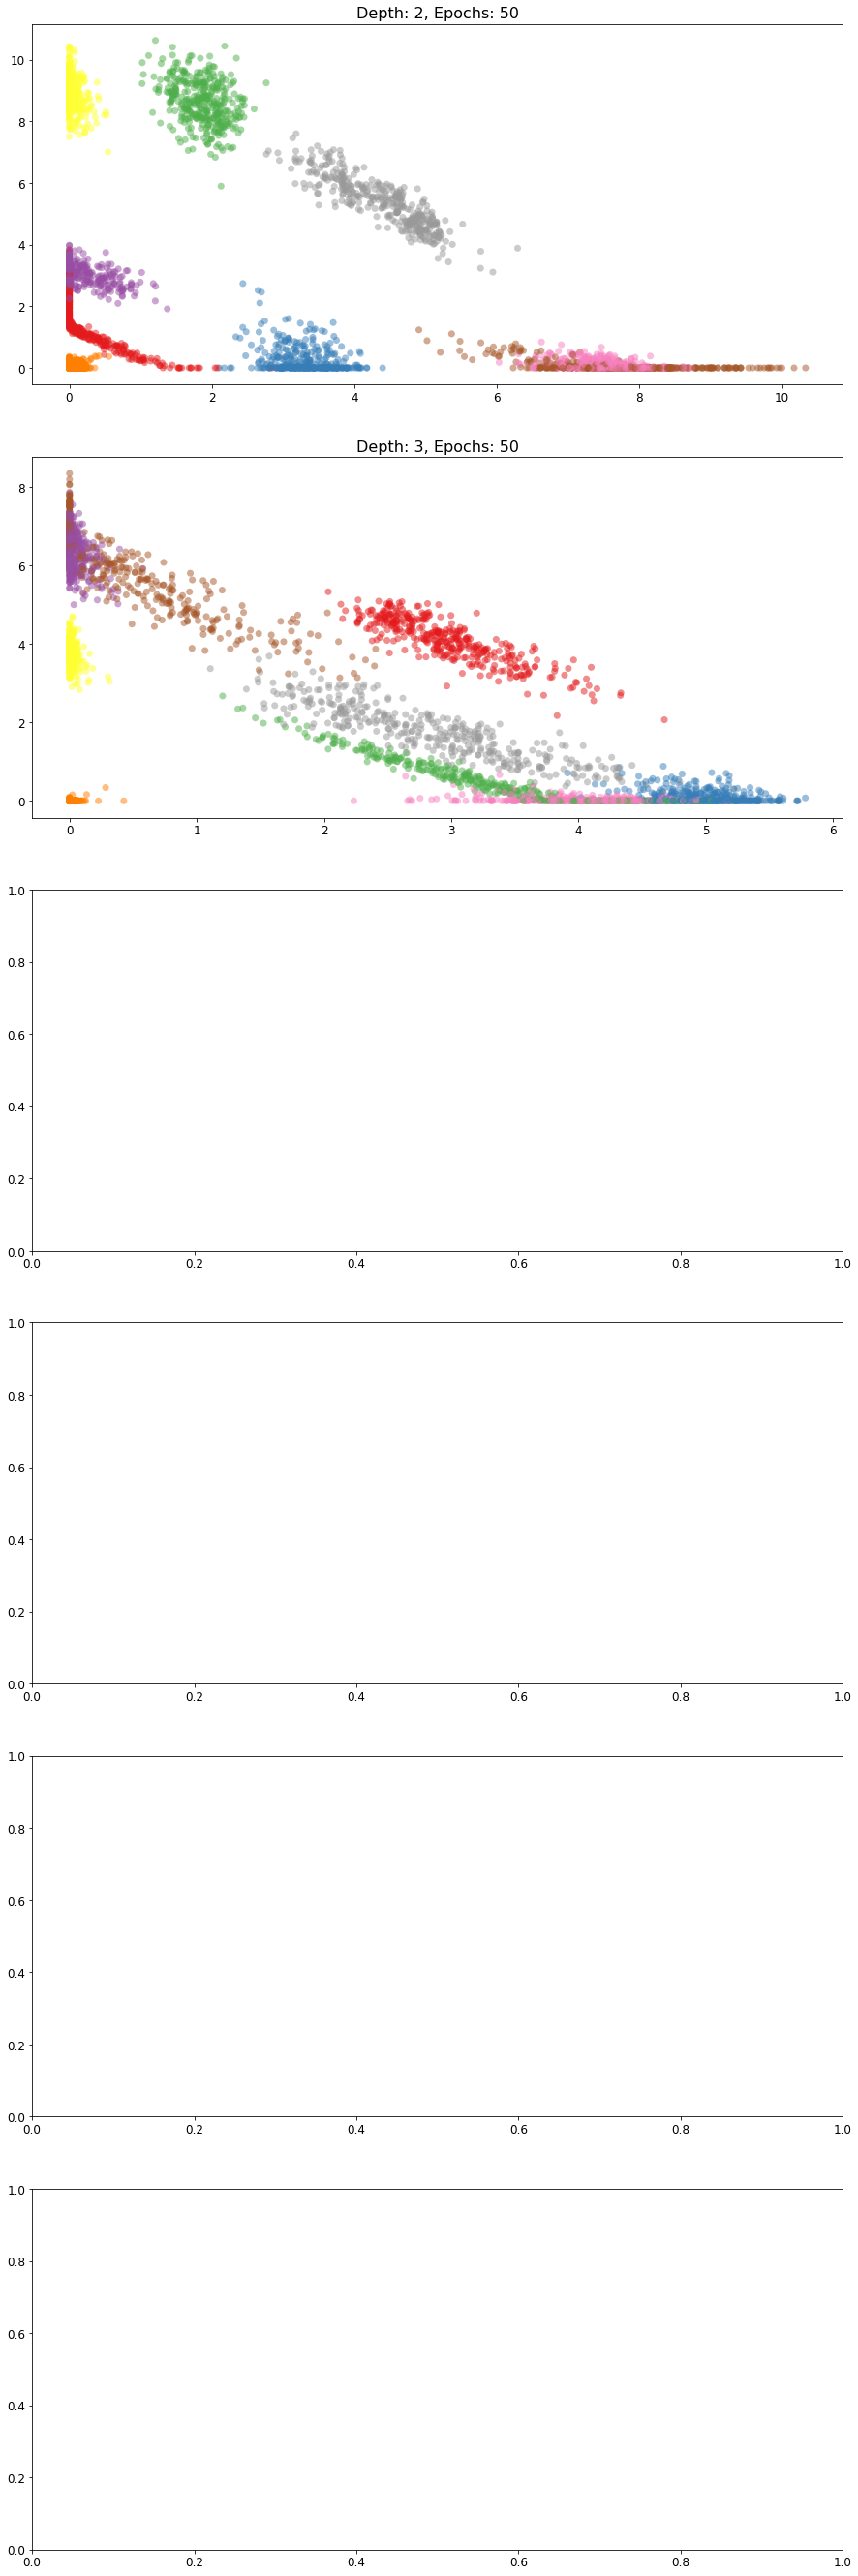

In [11]:
depth_epochs = [(2,50),(3,50),(4,100),(5,100), (5,200), (6,100)]#SWITCH FROM DICTIONARY TO LIST PLS

plt.close("Depth Comparison")
fig, axs = plt.subplots(len(depth_epochs),1, figsize=(15,8*len(depth_epochs)), num="Depth Comparison")
# plt.tight_layout()

for i,(d, epochs) in enumerate(depth_epochs):
    
    final_acc, lrp_results, lrp_labels = runDNN(d, epochs)
    
    pos_lrp = lrp_results.copy()
    pos_lrp[pos_lrp<0] = 0
    data = pos_lrp

    axs[i].scatter(*data.T, s=50, linewidth=0, c=lrp_labels, alpha=0.5, cmap=plot_args["cmap"])
    axs[i].set_title("Depth: {}, Epochs: {}".format(d, epochs))


# Depth Comparison with Cross Folds

In [21]:
def getKF(X,y, n_splits=10):
    from sklearn.model_selection import StratifiedKFold as KFold
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42 ) #Default = 10

    for train_index, test_index in kf.split(X,y):
        yield train_index, test_index

Creating data...


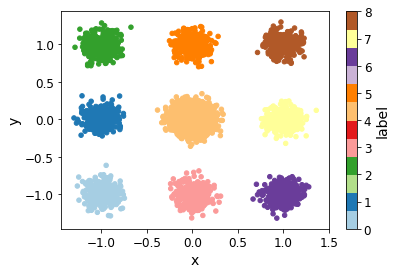

In [25]:
from time import time

depth_epochs = [(2,50),(3,50)]
# depth_epochs = [(2,50),(3,50),(4,100),(5,100), (5,200), (6,100)]

original_data, modded_samples, training_labels, original_labels = simulate_blobs(class_size=3000)
X, y, y_original, X_valid, y_valid, y_valid_original = split_valid(modded_samples, original_labels, training_labels)

hot_encoder = dfHotEncoder()
hot_encoder.fit(training_labels)

def runDNN(depth, epochs, train_data, test_data):
    nn = build_dnn(NUM_FEATURES)
    X_train, y_train = train_data
    X_test, y_test = test_data

    history, ZScaler = train_model(nn, X_train, y_train, 
                                   epochs=epochs, batch_size=20)

    scaled_samples = ZScaler.transform(X_test)
    final_acc = nn.evaluate(scaled_samples,hot_encoder.transform(y_test), verbose=0)

    # Getting all the samples that can be correctly predicted
    all_samples, _labels, correct_idxs = getCorrectPredictions(nn, scaled_samples, y_test, enc = hot_encoder)

    # Stripping the softmax activation from the model
    model_w_softmax = nn
    model = iutils.keras.graph.model_wo_softmax(model_w_softmax)

    # Creating an analyzer
    lrp_E = innvestigate.analyzer.relevance_based.relevance_analyzer.LRPEpsilon(model=model, epsilon=1e-3)
    lrp_results = lrp_E.analyze(all_samples)

    return (final_acc, lrp_results, correct_idxs)

def runCV(depth,epoch):
    
    start_time = time()
    
    histories = []
    testing_indxs =[]
    predictions = []
    true_labels = []
    cv_original_labels = []
    cv_lrp_results = []
    zoo = []
    
    for i, (train_index, test_index) in enumerate(getKF(X, y_original)):

        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        X_test  = X.iloc[test_index]
        y_test = y.iloc[test_index]
        y_test_original = y_original.iloc[test_index]

        final_acc, lrp_results, lrp_idxs = runDNN(depth, epoch, train_data = [X_train,y_train], test_data = [X_test, y_test])

        cv_original_labels.extend(y_test_original[lrp_idxs])
        cv_lrp_results.extend(lrp_results)

        print("Fold {} scores: loss={:0.3f} accuracy={:.4f}".format(
            i, final_acc[0], final_acc[1]))

    print("{}/{} Runtime: {:.3f}s".format(depth, epoch, time()-start_time))

    return (cv_lrp_results, cv_original_labels)

Prediction Accuracy
302/302 [==============================] - 0s 13us/step
Scores on data set: loss=0.002 accuracy=1.0000
Fold 0 scores: loss=0.002 accuracy=1.0000
Prediction Accuracy
302/302 [==============================] - 0s 14us/step
Scores on data set: loss=0.002 accuracy=1.0000
Fold 1 scores: loss=0.002 accuracy=1.0000
Prediction Accuracy
302/302 [==============================] - 0s 14us/step
Scores on data set: loss=0.002 accuracy=1.0000
Fold 2 scores: loss=0.002 accuracy=1.0000
Prediction Accuracy
302/302 [==============================] - 0s 15us/step
Scores on data set: loss=0.001 accuracy=1.0000
Fold 3 scores: loss=0.001 accuracy=1.0000
Prediction Accuracy
302/302 [==============================] - 0s 13us/step
Scores on data set: loss=0.001 accuracy=1.0000
Fold 4 scores: loss=0.001 accuracy=1.0000
Prediction Accuracy
302/302 [==============================] - 0s 16us/step
Scores on data set: loss=0.002 accuracy=1.0000
Fold 5 scores: loss=0.002 accuracy=1.0000
Prediction

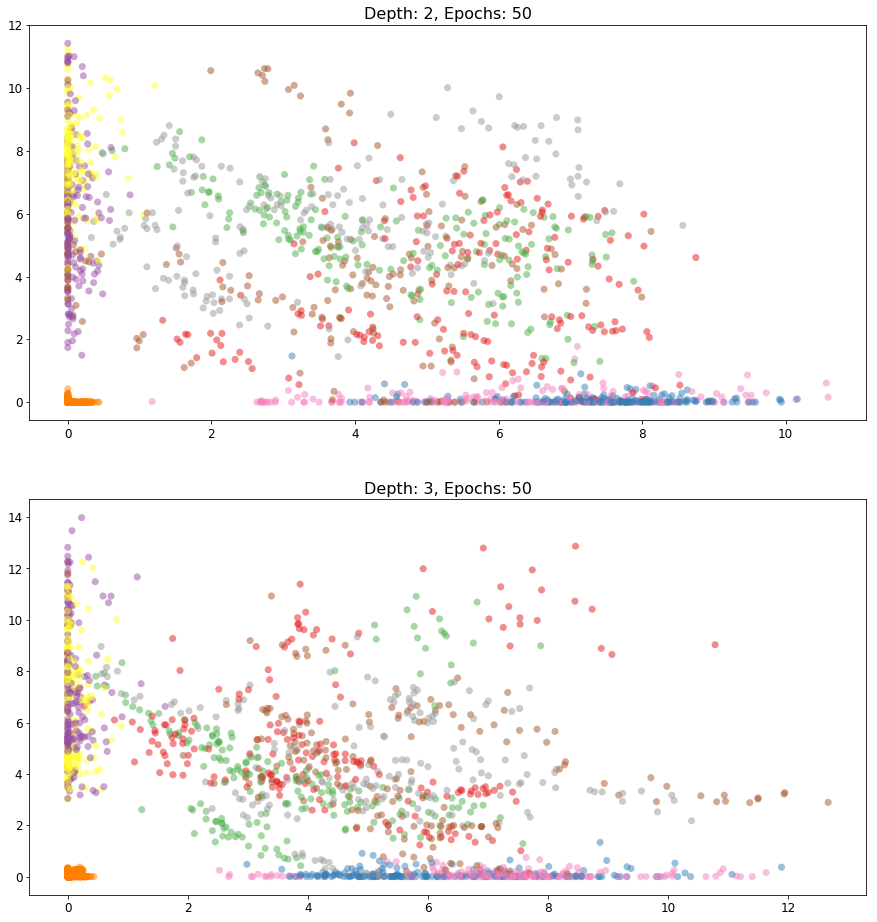

In [26]:
plt.close("CV Depth Comparison")
fig, axs = plt.subplots(len(depth_epochs),1, figsize=(15,8*len(depth_epochs)), num="CV Depth Comparison")
# plt.tight_layout()

runData = []
runLabels = []

for i,(d, epochs) in enumerate(depth_epochs):
    
    lrp_results, lrp_labels = runCV(d, epochs)
    
    pos_lrp = np.array(lrp_results)
    pos_lrp[pos_lrp<0] = 0
    data = pos_lrp
    runData.append(data)
    runLabels.append(lrp_labels)
    
#     noise = list(cluster_labels).count(-1)/len(cluster_labels)
#     hscore,cscore,vscore = metrics.homogeneity_completeness_v_measure(y_valid_original, cluster_labels)
#     sil_score = metrics.silhouette_score(data, cluster_labels, metric="euclidean")
    
#     _metrics.append([num_clusters,noise,sil_score,hscore,cscore,vscore])
    
    
    axs[i].scatter(*data.T, s=50, linewidth=0, c=lrp_labels, alpha=0.5, cmap=plot_args["cmap"])
    axs[i].set_title("Depth: {}, Epochs: {}".format(d, epochs))

## Generating Clusters  

In [29]:
import hdbscan
from sklearn import metrics
import seaborn as sns
%matplotlib inline
# sns.set_context('poster')
# sns.set_style('white')
plt.rcParams['axes.titlesize'] = 16
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

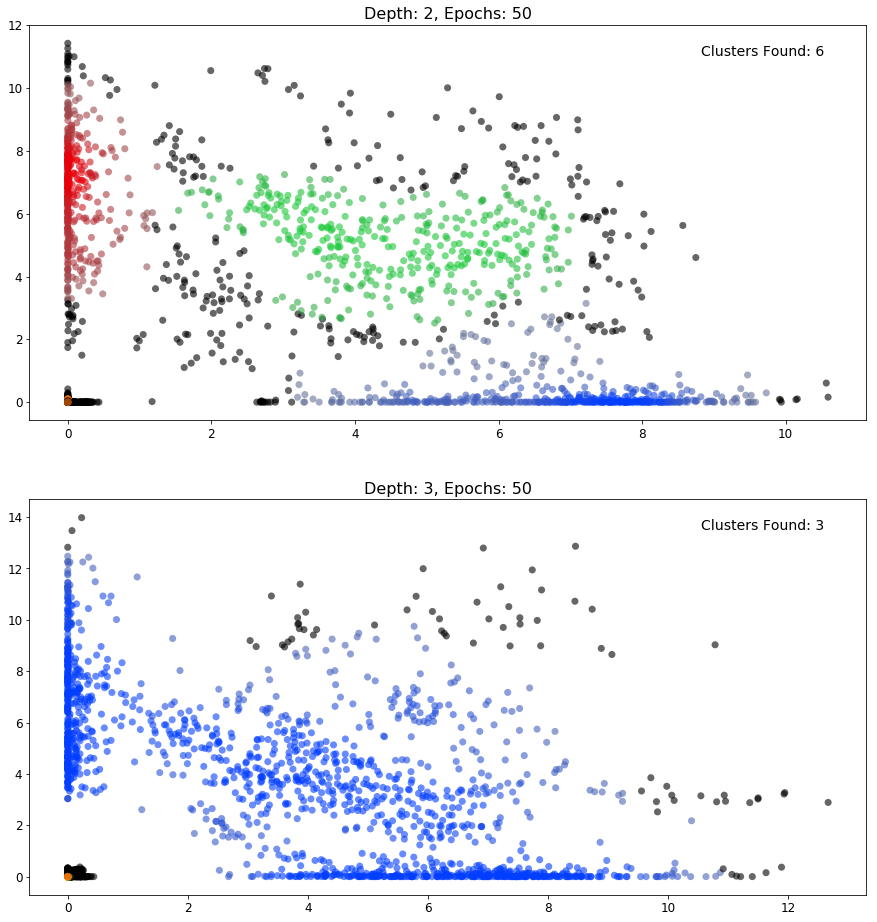

In [31]:
# cluster_sizes = [15,25,35,50,65,100]
plt.close("Cluster Comparison")
fig, axs = plt.subplots(len(depth_epochs),1, figsize=(15,8*len(depth_epochs)), num="Cluster Comparison")
plt.title("Cluster Comparison")


# axs[0].scatter(*data.T, s=50, linewidth=0, c=pos_lrp["label"].values, alpha=0.5, cmap=plot_args["cmap"])
# axs[0].set_title("Original LRP Distribution")

_metrics = []
cluster_size = 50

for i,(d, epochs) in enumerate(depth_epochs):
    clusterer = hdbscan.HDBSCAN(min_cluster_size=cluster_size)
    data = runData[i]
    y_valid_original = runLabels[i]
    
    clusterer.fit(data)
    cluster_labels = clusterer.labels_
    
     ## Number of clusters in labels, ignoring noise if present.
    num_clusters = cluster_labels.max() + 1
    
    color_palette = sns.color_palette("bright", num_clusters)
    cluster_colors = [color_palette[x] if x >= 0
                      else (0, 0, 0)
                      for x in clusterer.labels_]
    cluster_member_colors = [sns.desaturate(x, p) for x, p in
                             zip(cluster_colors, clusterer.probabilities_)]
    
    
#     _, ymax = axs[i+1].get_ylim()
#     _, xmax = axs[i+1].get_xlim()
    
   
    noise = list(cluster_labels).count(-1)/len(cluster_labels)
    hscore,cscore,vscore = metrics.homogeneity_completeness_v_measure(y_valid_original, cluster_labels)
    sil_score = metrics.silhouette_score(data, cluster_labels, metric="euclidean")
    _metrics.append([num_clusters,noise,sil_score,hscore,cscore,vscore])
    
    
    axs[i].scatter(*data.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.6)
    axs[i].set_title("Depth: {}, Epochs: {}".format(d, epochs))
    axs[i].text(0.95,0.95,"Clusters Found: {}".format(num_clusters),
                horizontalalignment='right', verticalalignment='top',
                fontsize=14, transform=axs[i].transAxes)

# plt.tight_layout()
plt.show()

In [1]:
scores = pd.DataFrame(_metrics, columns=["Clusters", "Noise", "Silhouette", "Homogeneity", "Completeness", "V-Measure"], index=depth_epochs)
scores

NameError: name 'pd' is not defined

In [ ]:
plt.close("Cluster Scores")
fig, axs = plt.subplots(figsize=(20,18), num="Cluster Scores")
plt.title("Cluster Scores")
scores.plot(kind="bar", ax=axs, subplots=True, layout=(3,3), grid = True)

In [24]:
plot_args

{'kind': 'scatter',
 'x': 0,
 'y': 1,
 'c': 'label',
 'cmap': 'Set1',
 's': 10,
 'alpha': 0.25}